In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

In [2]:
# Helper function to print loss function and accuracy history
def history(model):
    plt.figure(figsize = (15, 5) )

    plt.subplot(121)
    plt.plot(model.history['loss'], color='blue', label='train')
    plt.plot(model.history['val_loss'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')

    plt.subplot(122)
    plt.plot(model.history['binary_accuracy'], color = 'blue', label='train')
    plt.plot(model.history['val_binary_accuracy'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

In [3]:
# Helper function to calculate results
def true_pos(y_true, y_pred):
    return np.sum(y_true * y_pred)


def false_pos(y_true, y_pred):
    return np.sum(y_true * (1. - y_pred))


def false_neg(y_true, y_pred):
    return np.sum((1. - y_true) * y_pred)


def precision(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_pos(y_true, y_pred))


def recall(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_neg(y_true, y_pred))


def f1_score(y_true, y_pred):
    return 2. / (1. / recall(y_true, y_pred) + 1. / precision(y_true, y_pred))

### Feature Engineering

In [2]:
train_label = pd.read_csv("Data/train.csv")
train_label.head()

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


In [3]:
train_label['labels'] = train_label['labels'].apply(lambda x:str(x).split(' '))
train_label.head()

,business_id,labels
0,1000,"[1, 2, 3, 4, 5, 6, 7]"
1,1001,"[0, 1, 6, 8]"
2,100,"[1, 2, 4, 5, 6, 7]"
3,1006,"[1, 2, 4, 5, 6]"
4,1010,"[0, 6, 8]"


In [4]:
train_biz = pd.read_csv("Data/train_photo_to_biz_ids.csv")
train_biz.head()

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485


In [5]:
# Load train images
X_train = []

for i in tqdm(range(len(train_biz))):
    img_path = "Data/train_photos/" + str(train_biz.photo_id[i]) + '.jpg'
    img = image.load_img(img_path, target_size=(120, 120))
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    X_train.append(X)

100%|██████████████████████████████████| 234842/234842 [06:52<00:00, 569.35it/s]


In [6]:
features_train = pd.DataFrame({'features' : X_train})
train_merge = pd.concat([features_train, train_biz], axis=1)
train_merge.head()

,features,photo_id,business_id
0,"[[[[ 76. 102. 119.], [40. 57. 65.], [20. 24. 2...",204149,3034
1,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",52779,2805
2,"[[[[191. 141. 130.], [233. 169. 160.], [243. 2...",278973,485
3,"[[[[59. 58. 54.], [51. 48. 43.], [78. 87. 86.]...",195284,485
4,"[[[[ 96. 101. 95.], [ 96. 104. 89.], [ 97. 1...",19992,485


In [7]:
train_comp = train_merge.merge(train_label, on='business_id', how='left')
train_comp.shape

(234842, 4)

In [8]:
# Randomly select 10 sample from each business
train_sample = pd.DataFrame(columns=train_comp.columns)
for i in list(train_label['business_id']):
    temp_df = train_comp[train_comp.business_id == i].sample(np.minimum(10, len(train_comp[train_comp.business_id == i])))
    train_sample = train_sample.append(temp_df)

In [9]:
train_sample = train_sample.reset_index()
train_sample.drop('index', axis=1, inplace=True)
train_sample

,features,photo_id,business_id,labels
0,"[[[[197. 158. 103.], [195. 150. 93.], [185. 1...",134375,1000,"[1, 2, 3, 4, 5, 6, 7]"
1,"[[[[ 86. 95. 110.], [ 86. 102. 118.], [103. 1...",360032,1000,"[1, 2, 3, 4, 5, 6, 7]"
2,"[[[[80. 73. 57.], [81. 74. 58.], [82. 75. 59.]...",213116,1000,"[1, 2, 3, 4, 5, 6, 7]"
3,"[[[[137. 157. 168.], [151. 170. 187.], [179. 1...",253623,1000,"[1, 2, 3, 4, 5, 6, 7]"
4,"[[[[39. 25. 40.], [36. 28. 43.], [27. 25. 39.]...",368729,1000,"[1, 2, 3, 4, 5, 6, 7]"
...,...,...,...,...
19898,"[[[[153. 80. 35.], [147. 89. 49.], [148. ...",42254,999,"[1, 2, 5, 6, 7]"
19899,"[[[[32. 31. 39.], [32. 31. 37.], [35. 34. 39.]...",411563,999,"[1, 2, 5, 6, 7]"
19900,"[[[[5. 3. 6.], [6. 4. 7.], [4. 2. 5.], [4. 2. ...",451965,999,"[1, 2, 5, 6, 7]"
19901,"[[[[223. 208. 205.], [224. 209. 202.], [226. 2...",123397,999,"[1, 2, 5, 6, 7]"


### Modeling

In [11]:
train_df = train_sample[['features', 'labels']]
train_df.shape

(19903, 2)

In [13]:
# Remove nan values
train_df['labels'] = train_df['labels'].apply(lambda x: [i for i in x if str(i) != "nan"])

/var/folders/zy/490c7q0j7c72hr16lfsxvg5w0000gn/T/ipykernel_37371/2897397416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'] = train_df['labels'].apply(lambda x: [i for i in x if str(i) != "nan"])


In [14]:
train_df.to_pickle('train_df.csv')

In [4]:
import pickle as pickle
with open('train_df.csv', "rb") as fh:
      train_df = pickle.load(fh)

In [5]:
# One-hot encoding of labels
from sklearn.preprocessing import MultiLabelBinarizer

# Process train & test set into an array format
X = np.array([x for x in train_df['features']])
X = np.asarray(X).astype(np.float32)

y = train_df['labels']
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Check shape of array-format train & test set 
print("X: ", X.shape)
print("y: ", y.shape)

X:  (19903, 1, 120, 120, 3)
y:  (19903, 9)


In [6]:
mlb.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dtype=object)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [8]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 120
X_val /= 120

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3], X_train.shape[4])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[2], X_val.shape[3], X_val.shape[4])

In [9]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (15922, 120, 120, 3)
y_train:  (15922, 9)


In [10]:
epochs = 100
batch_size = 64
n_outputs = y_train.shape[1]

### MLP

In [42]:
from keras.regularizers import l2
model = Sequential()
model.add(Flatten(input_shape=(120, 120, 3)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))
model.add(Dense(n_outputs, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 43200)             0         
                                                                 
 dense_39 (Dense)            (None, 1024)              44237824  
                                                                 
 dense_40 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_41 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_42 (Dense)            (None, 256)               262400    
                                                                 
 dense_43 (Dense)            (None, 256)              

In [43]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.00001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])

In [44]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_mlp = model.fit(X_train, y_train, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          validation_data=(X_val, y_val),
                          callbacks=early_stopping_cb)

Epoch 1/100
249/249 [==============================] - 24s 95ms/step - loss: 1.4520 - binary_accuracy: 0.6120 - val_loss: 1.4227 - val_binary_accuracy: 0.6325
Epoch 2/100
249/249 [==============================] - 24s 97ms/step - loss: 1.3925 - binary_accuracy: 0.6265 - val_loss: 1.3602 - val_binary_accuracy: 0.6351
Epoch 3/100
249/249 [==============================] - 24s 98ms/step - loss: 1.3425 - binary_accuracy: 0.6338 - val_loss: 1.3161 - val_binary_accuracy: 0.6434
Epoch 4/100
249/249 [==============================] - 24s 95ms/step - loss: 1.3037 - binary_accuracy: 0.6404 - val_loss: 1.2858 - val_binary_accuracy: 0.6417
Epoch 5/100
249/249 [==============================] - 24s 95ms/step - loss: 1.2712 - binary_accuracy: 0.6419 - val_loss: 1.2536 - val_binary_accuracy: 0.6448
Epoch 6/100
249/249 [==============================] - 24s 94ms/step - loss: 1.2416 - binary_accuracy: 0.6457 - val_loss: 1.2286 - val_binary_accuracy: 0.6470
Epoch 7/100
249/249 [=========================

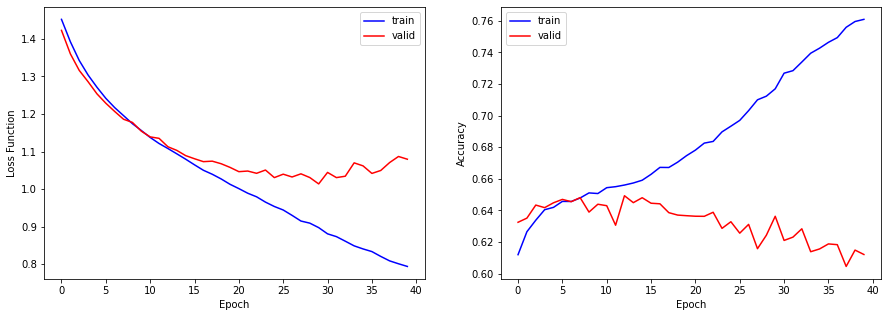

In [45]:
history(history_mlp)

In [46]:
mlp_predictions = (model.predict(X_val) >= 0.5).astype(int)

In [47]:
# F1 Score
mlp_score = f1_score(y_val, mlp_predictions)
print('F1 score: %.5f' % mlp_score)

F1 score: 0.61143


### Base CNN

In [15]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.00001, decay=1e-6)
cnn = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(120, 120, 3)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(n_outputs, activation='sigmoid')
])

cnn.compile(optimizer = sgd, loss='binary_crossentropy', metrics=['binary_accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 120, 120, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)      

/Users/WilliamDai/miniforge3/envs/TFmacOS/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/Users/WilliamDai/miniforge3/envs/TFmacOS/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_cnn = cnn.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(X_val, y_val),
                      callbacks=early_stopping_cb)

Epoch 1/100


2022-05-31 13:24:26.998230: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


249/249 [==============================] - 394s 2s/step - loss: 0.6506 - binary_accuracy: 0.6347 - val_loss: 0.6631 - val_binary_accuracy: 0.6445
Epoch 2/100
249/249 [==============================] - 407s 2s/step - loss: 0.6336 - binary_accuracy: 0.6501 - val_loss: 0.6364 - val_binary_accuracy: 0.6521
Epoch 3/100
249/249 [==============================] - 410s 2s/step - loss: 0.6265 - binary_accuracy: 0.6579 - val_loss: 0.6235 - val_binary_accuracy: 0.6573
Epoch 4/100
249/249 [==============================] - 406s 2s/step - loss: 0.6213 - binary_accuracy: 0.6619 - val_loss: 0.6223 - val_binary_accuracy: 0.6578
Epoch 5/100
249/249 [==============================] - 407s 2s/step - loss: 0.6163 - binary_accuracy: 0.6666 - val_loss: 0.6195 - val_binary_accuracy: 0.6613
Epoch 6/100
249/249 [==============================] - 409s 2s/step - loss: 0.6115 - binary_accuracy: 0.6704 - val_loss: 0.6192 - val_binary_accuracy: 0.6599
Epoch 7/100
249/249 [==============================] - 399s 2s/s

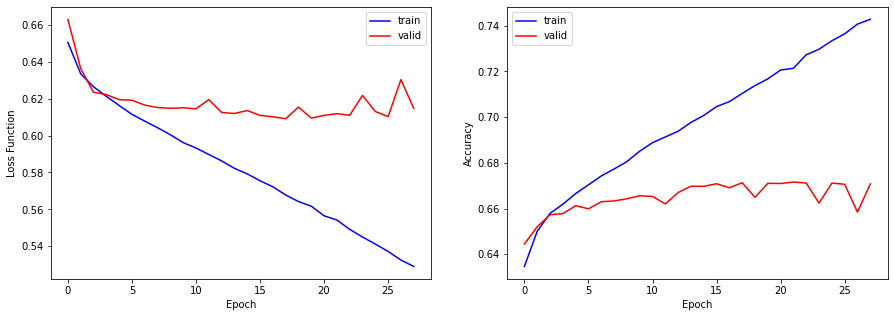

In [20]:
history(history_cnn)

In [21]:
cnn_predictions = (cnn.predict(X_val) >= 0.5).astype(int)

In [22]:
# F1 Score
cnn_score = f1_score(y_val, cnn_predictions)
print('F1 score: %.5f' % cnn_score)

F1 score: 0.65265
